# ORÁCULO: Primitiva

http://www.lotoideas.com/primitiva-resultados-historicos-de-todos-los-sorteos/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

import time
import operator

Using TensorFlow backend.


In [2]:
debug = False
def log(*params):
    if debug:
        for x in params:
            print(x)

In [3]:
#Cargar datos
datos = pd.read_csv('datos/Primitiva_2013_2018.csv')

try:
    datos = datos.drop(labels=['comp'], axis=1)
except:
    None #Ya lo eliminaste en el fichero?

log(datos.head(), "\n")
    
#Poner los datos mas recientes al final...
datos = datos.reindex(index=datos.index[::-1])

log(datos.head(), "\n")

max = datos.max(1).max()
min = datos.min(1).min()
log("MAX: ", max)#49
log("MIN: ", min)# 1
log("DIM: ", datos.shape)
features = max - min +1

### -----------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
#Muestra una grafica de la evolucion del error de training y validacion
def grafica(hist, offset0 = 0, offset1 = None):
    loss = hist.history['loss'][offset0:offset1]
    val_loss = hist.history['val_loss'][offset0:offset1]
    epochs = range(offset0 + 1, len(loss) + offset0 + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
#Funciones para mostrar tiempo transcurrido
def print_time(time_ini):
    sec = round(time.time() - time_ini)
    min = 0
    if(sec > 60):
        min = sec // 60
        sec = sec & 60
    print("TIME: ", min, "m  ", sec, "s")

def ini_time():
    print("Procesando... ", time.ctime())
    return time.time()

In [6]:
import winsound
def beep():
    duration = 500  # millisecond
    freq = 900  # Hz
    winsound.Beep(freq, duration)
    winsound.Beep(freq, duration)
    winsound.Beep(freq, 2*duration)

In [7]:
#Calcula el error incurrido en la predicción
import math
##
def calc_error_all(pred, real):
    error = []
    for i in range(len(real)):
        error.append(0)
        for j in range(len(real[i])):
            if(real[i][j] not in pred[i]):
                error[i] += 1
    for i in range(len(error)):
        error[i] = math.floor(error[i]*100.0/6.0)
    return error
##
def calc_error_one(pred, real):
    error = 0
    for j in range(len(real)):
        if(real[j] not in pred):
            error += 100.0/6.0
    return error

In [8]:
#TODO: Si el peor de los mejores esta repetido, alguno mejor podria no entrar en la lista
def translate_all(pred):
    numeros = []
    for i in range(pred.shape[0]):
        min_mas_alto = sorted(pred[i], key=float, reverse=True)[5]
        #print(i, " min: ", min_mas_alto)
        numeros.append([])
        for j in range(pred.shape[1]):
            if pred[i][j] >= min_mas_alto and len(numeros[i]) < 6:
                numeros[i].append(j)
        #print(i, " num: ", numeros[i])
    return numeros

def translate_one(pred):
    numeros = []
    min_mas_alto = sorted(pred, key=float, reverse=True)[5]
    for j in range(pred.shape[0]):
        if pred[j] >= min_mas_alto and len(numeros) < 6:
            numeros.append(j)
    return numeros

In [9]:
#Convierte los numeros enteros premiados en un array binario ONE HOT

##
def vectorize_all(sequences, dimension=features):
    res = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        res[i, sequence-min] = 1
    return res

##
def devectorize_one(valor):
    res = []
    for i in range(len(valor)):
        if(valor[i] > 0):
            res.append(i+min)
    return res
#print(devectorize(np.array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0])), "\n")

##
def devectorize_all(valores):
    i = 0
    res = []
    for valor in valores:
        res.append([])
        for j in range(len(valor)):
            if(valor[j] > 0):
                res[i].append(j+min)
        i+=1
    return res

### -----------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
numeros = datos.drop(labels=['fecha'], axis=1)

log("----------------------------------------\n")
log(numeros.head())
log("----------------------------------------\n")
log(np.array(numeros))
log("----------------------------------------\n")

num_hot = vectorize_all(np.array(numeros))

log(num_hot)
log("----------")
log(devectorize_one(num_hot[0]))
log(devectorize_one(num_hot[1]))
log(devectorize_one(num_hot[2]))
log("...")

In [11]:
#Divide los datos en secuencias que el modelo tendrá que aprender
seq_len = 100
secuencias = []
log(len(num_hot), seq_len)
for index in range(len(num_hot) - seq_len):
    secuencias.append(num_hot[index : index + seq_len])
secuencias = np.array(secuencias)
###
log(devectorize_one(num_hot[0]))
log(devectorize_one(secuencias[0][0]))
log()
log(devectorize_one(num_hot[seq_len-1]))
log(devectorize_one(secuencias[0][seq_len-1]))
log()
log(devectorize_one(num_hot[1]))
log(devectorize_one(secuencias[1][0]))
log()
log(devectorize_one(num_hot[1+seq_len-1]))
log(devectorize_one(secuencias[1][seq_len-1]))
log()

log(devectorize_one(secuencias[0][0]))
log("...")


In [12]:
#Divide los datos en Training y Test
log(secuencias.shape)

row = round(0.9 * secuencias.shape[0])
train = secuencias[:int(row), :]

log(train.shape)
log(devectorize_one(train[0][0]))
log(devectorize_one(secuencias[0][0]))

#np.random.shuffle(train)

x_train = train[:, :-1]#Todos menos el ultimo valor, que es el que hay que predecir
log(x_train.shape)
log(x_train[0][0])

y_train = train[:, -1] #El ultimo valor, que es el que interesa predecir
log(y_train.shape)
x_test = secuencias[int(row):, :-1]
log(x_test.shape)
y_test = secuencias[int(row):, -1]
log(y_test.shape)


In [13]:

log(x_train.shape,  seq_len)

log()
log(devectorize_one(num_hot[0]))
log(devectorize_one(x_train[0][0]))
log()
log(devectorize_one(num_hot[seq_len-2]))
log(devectorize_one(x_train[0][seq_len-2]))
log()
log(devectorize_one(num_hot[seq_len-1]))
log(devectorize_one(y_train[0]))
log()
log(devectorize_one(num_hot[x_train.shape[0]+seq_len-2]))
log(devectorize_one(x_test[0][seq_len-2]))
log()
log(devectorize_one(num_hot[x_train.shape[0]+seq_len-1]))


### -----------------------------------------------------------------------------------------------------------------------------------------------
### -----------------------------------------------------------------------------------------------------------------------------------------------

### Objetivo minimo: 3 numeros de 6 => 50% !!!

model1 ->

4 capas LSTM, 1 densa, epoca=, batch=128, m0s/0e -> 

5 capas LSTM, 1 densa, epoca=150, batch=128, 4m20s/0e -> OK TRAIN = 12.41 / OK TEST = 11.47

6 capas LSTM, 1 densa, epoca=150, batch=128, 5m20s/150e -> OK TRAIN = 12.90 / OK TEST = 11.07   (0.10842311382293701)

                       epoca=101                                      11.89             13.02


1 capa LSTM, 1 bidireccional, epoca=25, batch=128, 0m39s/25e -> OK TRAIN = 11.75 / OK TEST = 14.34

In [36]:
#Crea la RNN
#features = x_train.shape[2]
def build_model():
    model = models.Sequential()
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    #model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))

    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=False))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Dense(units=features, activation='sigmoid'))
    #model.add(layers.Dense(units=features))
    #model.add(layers.Activation("linear"))

    #start = time.time()
    #model.compile(loss="mse", optimizer="rmsprop")
    model.compile(loss="mse", optimizer="rmsprop")
    #print("> Compilation Time : ", round(time.time() - start), " segundos")
    return model


In [15]:
#Entrenar la RNN
batch_size=128
epochs = 150
model = build_model()
timeini = ini_time()
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
print_time(timeini)

Procesando...  Fri Feb  2 10:48:21 2018
TIME:  4 m   20 s


Val.Loss:  0.10810329765081406


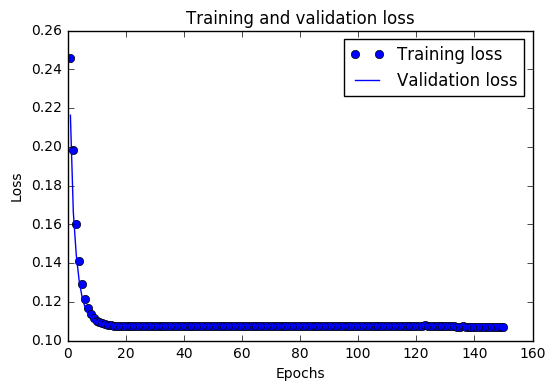

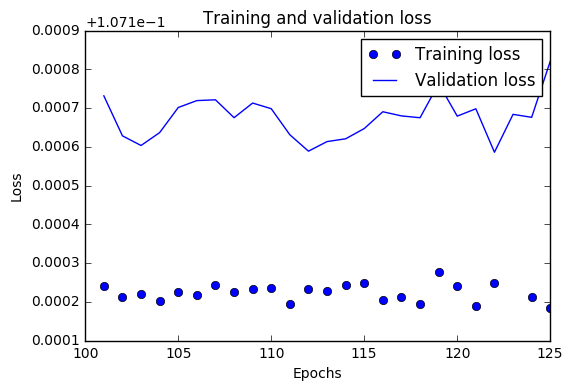

In [25]:
print("Val.Loss: ", hist.history['val_loss'][epochs-1])
grafica(hist)
grafica(hist, 100,125)

In [18]:
#Error Train
numeros_ganadores = translate_all(model.predict(x_train))
error = calc_error_all(numeros_ganadores, devectorize_all(y_train))
err = 0
for x in error:
    err += x
    
error100 = err/len(error)
acierto100 = 100 - error100
#print("\nERROR   TRAIN: %.2f -------------------------------" % error100)
print("\nACIERTO TRAIN: %.2f -------------------------------\n" % acierto100)


ACIERTO TRAIN: 12.41 -------------------------------



In [19]:
#Error Test
numeros_ganadores = translate_all(model.predict(x_test))

error = calc_error_all(numeros_ganadores, devectorize_all(y_test))
log("ERROR: ", error)
err = 0
for x in error:
    err += x
    
error100 = err/len(error)
acierto100 = 100 - error100
#print("\nERROR:  TEST: %.2f -------------------------------" % error100)
print("\nACIERTO TEST: %.2f -------------------------------\n" % acierto100)


ACIERTO TEST: 11.47 -------------------------------



In [20]:
if(acierto100 > 11.5):
    model.save("lotoA"+str(acierto100)+".h5")

### -----------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
#Train again with the better epoch
timeini = ini_time()
best_epoch = 112
model2 = build_model()
hist2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=best_epoch, validation_split=0.05, verbose=0)
print_time(timeini)

Procesando...  Fri Feb  2 11:14:08 2018
TIME:  3 m   24 s


Val.Loss:  0.10772813856601715


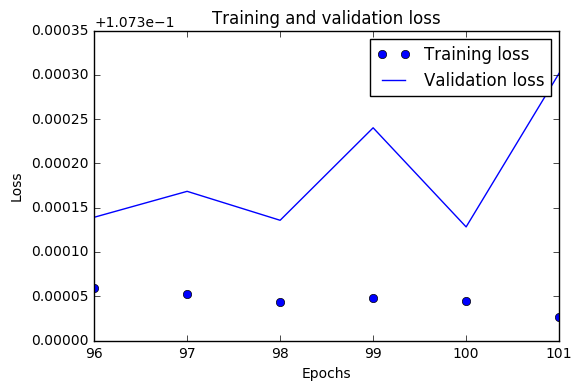

In [22]:
print("Val.Loss: ", hist.history['val_loss'][best_epoch])
grafica(hist2, 95)

In [26]:
numeros_ganadores = translate_all(model2.predict(x_train))
error = calc_error_all(numeros_ganadores, devectorize_all(y_train))
err = 0
for x in error:
    err += x
    
error100 = err/len(error)
acierto100 = 100 - error100
#print("\nERROR TRAIN:   %.2f -------------------------------" % error100)
print("\nACIERTO TRAIN: %.2f -------------------------------\n" % acierto100)


ACIERTO TRAIN: 11.63 -------------------------------



In [27]:
numeros_ganadores = translate_all(model2.predict(x_test))
log("REAL: ", devectorize_one(y_test[0]), " vs PRED: ", numeros_ganadores[0], "\n")
##
error = calc_error_all(numeros_ganadores, devectorize_all(y_test))
log("ERROR: ", error)
err = 0
for x in error:
    err += x
    
error100 = err/len(error)
acierto100 = 100 - error100
#print("\nERROR   TEST: %.2f -------------------------------" % error100)
print("\nACIERTO TEST: %.2f -------------------------------\n" % acierto100)



ACIERTO TEST: 12.23 -------------------------------



In [28]:
if(acierto100 > 14):
    model2.save("bumodels/lotoB_"+str(acierto100)+".h5")

In [ ]:
#TODO: Modificar porcentage TRAIN / TEST a ver como responde...

### -----------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
#Predecir
print(secuencias.shape)
print(secuencias[-seq_len-1:-1].shape)
numeros_ganadores = model.predict(secuencias[-seq_len:-1])
numeros_ganadores = translate_one(numeros_ganadores[-1])
print(numeros_ganadores, " vs real ", devectorize_one(secuencias[-1][-1]))
print()

numeros_ganadores = model.predict(secuencias[-seq_len:])
numeros_ganadores = translate_one(numeros_ganadores[-1])
print("----------------------------------------------------------------")
print(numeros_ganadores)
print("----------------------------------------------------------------")


(430, 100, 49)
(100, 100, 49)
[1, 11, 27, 36, 40, 42]  vs real  [3, 6, 25, 31, 32, 40]

----------------------------------------------------------------
[1, 14, 27, 36, 40, 42]
----------------------------------------------------------------


In [30]:
print("X:\n========")
print(x_train.shape)
print()
n = 0
for i in x_train:
    m = 0
    if(n < 2 or n > x_train.shape[0]-2):
        for j in i:
            if(m < 2 or m > i.shape[0]-2):
                print(n, m, devectorize_one(j))
            elif(m==10):
                print("...")
            m += 1
        print("-----------------------------------")
    elif(n==10):
        print("[...]\n")
    n += 1

    
print("\nY:\n========")
print(y_train.shape)
print()
n = 0
for i in y_train:
    if(n < 2 or n > y_train.shape[0]-2):
        print(n,devectorize_one(i))
    elif(n==10):
        print("...")
    n += 1

X:
(387, 99, 49)

0 0 [3, 15, 23, 26, 34, 38]
0 1 [1, 4, 9, 11, 38, 48]
...
0 98 [13, 24, 28, 30, 43, 44]
-----------------------------------
1 0 [1, 4, 9, 11, 38, 48]
1 1 [29, 32, 34, 42, 44, 46]
...
1 98 [12, 16, 23, 27, 28, 41]
-----------------------------------
[...]

386 0 [7, 14, 24, 34, 35, 40]
386 1 [8, 14, 20, 22, 28, 32]
...
386 98 [7, 10, 12, 35, 38, 40]
-----------------------------------

Y:
(387, 49)

0 [12, 16, 23, 27, 28, 41]
1 [16, 23, 33, 38, 47, 49]
...
386 [7, 19, 23, 28, 42, 49]


In [31]:
print(devectorize_one(x_train[1][-1]), " corresponde con ", devectorize_one(y_train[0]))
print(devectorize_one(x_train[2][-1]), " corresponde con ", devectorize_one(y_train[1]))

[12, 16, 23, 27, 28, 41]  corresponde con  [12, 16, 23, 27, 28, 41]
[16, 23, 33, 38, 47, 49]  corresponde con  [16, 23, 33, 38, 47, 49]


In [32]:
#TRAIN
print(x_train.shape)
sum_error = 0
for i in range(len(y_train)):
    pred = model.predict(x_train[i:(i+1)+seq_len])
    pred = translate_one(pred[-1])
    real = devectorize_one(y_train[i])
    error  = calc_error_one(pred, real)
    sum_error += error
    #print(i, "\t", real, "\t", pred, "\t\t", error)

error = sum_error/len(y_train) 
#print("Error: ", error)
print("ACIERTO TRAIN: ", 100 - error)

(387, 99, 49)
ACIERTO TRAIN:  11.972437553833018


In [33]:
#TEST
print(x_test.shape)
sum_error = 0
for i in range(len(y_test)):
    pred = model.predict(x_test[i:(i+1)+seq_len])
    pred = translate_one(pred[-1])
    real = devectorize_one(y_test[i])
    error  = calc_error_one(pred, real)
    sum_error += error
    #print(i, "\t", real, "\t", pred, "\t\te:", error)

error = sum_error/len(y_test) 
#print("Error: ", error)
print("ACIERTO TEST: ", 100 - error)

(43, 99, 49)
ACIERTO TEST:  12.015503875968975


In [54]:
#RNN LSTM Bidireccional
def build_model2():
    model = models.Sequential()
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    #model.add(layers.Embedding(features, 32))
    model.add(layers.Bidirectional(layers.LSTM(input_shape=(None, features), units=features, return_sequences=False)))
    model.add(layers.Dense(features, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [ ]:
#Entrenar la RNN
batch_size=128
epochs = 150
model3 = build_model2()
timeini = ini_time()
hist = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
print_time(timeini)

Procesando...  Fri Feb  2 11:48:30 2018


In [ ]:
print("Val.Loss: ", hist.history['val_loss'][epochs-1])
grafica(hist)
grafica(hist, 20, 80)

In [ ]:
#TRAIN
print(x_train.shape)
sum_error = 0
for i in range(len(y_train)):
    pred = model.predict(x_train[i:(i+1)+seq_len])
    pred = translate_one(pred[-1])
    real = devectorize_one(y_train[i])
    error  = calc_error_one(pred, real)
    sum_error += error
    #print(i, "\t", real, "\t", pred, "\t\t", error)

error = sum_error/len(y_train) 
#print("Error: ", error)
print("ACIERTO TRAIN: ", 100 - error)

In [ ]:
#TEST
print(x_test.shape)
sum_error = 0
for i in range(len(y_test)):
    pred = model3.predict(x_test[i:(i+1)+seq_len])
    pred = translate_one(pred[-1])
    real = devectorize_one(y_test[i])
    error  = calc_error_one(pred, real)
    sum_error += error
    #print(i, "\t", real, "\t", pred, "\t\te:", error)

error = sum_error/len(y_test) 
#print("Error: ", error)
print("ACIERTO TEST: ", 100 - error)

In [ ]:
if(acierto100 > 14):
    model2.save("bumodels/lotoB_"+str(acierto100)+".h5")